# Keypoint(Patch) Description
<a id='top_cell'></a>  
This project will be all about defining and training a convolutional neural network to perform keypoint  description. 
PyTorch tutorials are available at here: [pytorch tutorials](https://github.com/yunjey/pytorch-tutorial)

Today we will go through:
### 1. [Load and visualize the data](#load_data_cell)
### 2. [Build an example deep network](#build_network_cell)
### 3. [Train the deep network](#train_network_cell)
### 4. [Generate deep features](#generate_deep_features_cell)

***

We will use below dataset in this project:
###  [The Photo Tourism dataset ](http://phototour.cs.washington.edu/patches/default.htm)

It is also available in PyTorch torchvision datasets: [pytorch version](https://pytorch.org/docs/stable/_modules/torchvision/datasets/phototour.html#PhotoTour)

This dataset consists of 1024 x 1024 bitmap (.bmp) images, each containing a 16 x 16 array of image patches. Here are some examples:

<table><tr><td><img src='images/patches0001.bmp' width=68% ></td><td><img src='images/patches1482.bmp' width=68%></td></tr></table>    
For details of how the scale and orientation is established, please see the paper:  
<p class="style8"><font size="2">S. Winder and M. Brown. <strong>Learning Local Image 
				Descriptors</strong>. To appear <i>International Conference on 
				Computer Vision and Pattern Recognition (CVPR2007)</i> (</font><a href="http://research.microsoft.com/~swinder/papers/winder_brown_cvpr07.pdf"><span class="style9">pdf 
				300Kb</span></a><font size="2">)</font></p>



---

### Import packages

In [1]:
from __future__ import division, print_function
import glob
import os
import warnings
warnings.simplefilter("ignore")
import cv2
import PIL
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import torch
import torch.nn.init
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
import torchvision.datasets as dset
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.autograd import Variable
from copy import deepcopy, copy
from config_profile import args
from Utils import cv2_scale36, cv2_scale, np_reshape, np_reshape64
from Utils import L2Norm, cv2_scale, np_reshape

### Check GPU availability, using nvidia-smi 

In [2]:
# Since there are two GPUs on each pelican server, you can either select it as 0 or 1
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
print(torch.__version__)
print(torch.version.cuda)  
print(torch.cuda.is_available())

1.8.1+cu101
10.1
True


---
---
<a id='load_data_cell'></a>
## Load and visualize the data

In this section, we will 
#### 1. [Define a PyTorch dataset](#pytorch_dataset_cell)
#### 2. [Define a PyTorch dataloader](#pytorch_dataloader_cell)
#### 3. [Load data](#load_dataset_cell)
#### 4. [Visualizaiton of the Training and Testing Data](#visualize_dataset_cell)

[BackToTop](#top_cell)

---

<a id='pytorch_dataset_cell'></a>
### Define PyTorch dataset

[BackToSection](#load_data_cell)

In [3]:
class TripletPhotoTour(dset.PhotoTour):
    """
    From the PhotoTour Dataset it generates triplet samples
    note: a triplet is composed by a pair of matching images and one of
    different class.
    """
    def __init__(self, train=True, transform=None, batch_size = None,load_random_triplets = False,  *arg, **kw):
        super(TripletPhotoTour, self).__init__(*arg, **kw)
        self.transform = transform
        self.out_triplets = load_random_triplets
        self.train = train
        self.n_triplets = args.n_triplets
        
        
        self.batch_size = batch_size
        self.triplets = self.generate_triplets(self.labels, self.n_triplets)
            
    @staticmethod
    def generate_triplets(labels, num_triplets):
        def create_indices(_labels):
            inds = dict()
            for idx, ind in enumerate(_labels):
                if ind not in inds:
                    inds[ind] = []
                inds[ind].append(idx)
            return inds

        triplets = []
        indices = create_indices(labels.numpy())
        unique_labels = np.unique(labels.numpy())
        n_classes = unique_labels.shape[0]
        # add only unique indices in batch
        already_idxs = set()

        for x in tqdm(range(num_triplets)):
            if len(already_idxs) >= args.batch_size:
                already_idxs = set()
            c1 = np.random.randint(0, n_classes)
            while c1 in already_idxs:
                c1 = np.random.randint(0, n_classes)
            already_idxs.add(c1)
            c2 = np.random.randint(0, n_classes)
            while c1 == c2:
                c2 = np.random.randint(0, n_classes)
            if len(indices[c1]) == 2:  # hack to speed up process
                n1, n2 = 0, 1
            else:
                n1 = np.random.randint(0, len(indices[c1]))
                n2 = np.random.randint(0, len(indices[c1]))
                while n1 == n2:
                    n2 = np.random.randint(0, len(indices[c1]))
            n3 = np.random.randint(0, len(indices[c2]))
            triplets.append([indices[c1][n1], indices[c1][n2], indices[c2][n3]])
        return torch.LongTensor(np.array(triplets))

    def __getitem__(self, index):
        def transform_img(img):
            if self.transform is not None:
                img = self.transform(img.numpy())
            return img

        t = self.triplets[index]
        a, p, n = self.data[t[0]], self.data[t[1]], self.data[t[2]]

        img_a = transform_img(a)
        img_p = transform_img(p)
        img_n = None
        if self.out_triplets:
            img_n = transform_img(n)
        # transform images if required
        if args.fliprot:
            do_flip = random.random() > 0.5
            do_rot = random.random() > 0.5
            if do_rot:
                img_a = img_a.permute(0,2,1)
                img_p = img_p.permute(0,2,1)
                if self.out_triplets:
                    img_n = img_n.permute(0,2,1)
            if do_flip:
                img_a = torch.from_numpy(deepcopy(img_a.numpy()[:,:,::-1]))
                img_p = torch.from_numpy(deepcopy(img_p.numpy()[:,:,::-1]))
                if self.out_triplets:
                    img_n = torch.from_numpy(deepcopy(img_n.numpy()[:,:,::-1]))
        return (img_a, img_p, img_n)
        

    def __len__(self):
        return self.triplets.size(0)
        

<a id='pytorch_dataloader_cell'></a>
### Define the dataloader
[BackToSection](#load_data_cell)

In [4]:
def create_loaders(dataset_names, load_random_triplets = False, verbose=False):
    """
    For training, we use dataset 'liberty';
    For testing, we use dataset 'notredame' and 'yosemite'
    
    """
    test_dataset_names = copy(dataset_names)
    test_dataset_names.remove(args.training_set)

    kwargs = {'num_workers': args.num_workers, 'pin_memory': args.pin_memory} if args.cuda else {}

    np_reshape64 = lambda x: np.reshape(x, (64, 64, 1))
    transform_test = transforms.Compose([
            transforms.Lambda(np_reshape64),
            transforms.ToPILImage(),
            transforms.Resize(32),
            transforms.ToTensor()])
    transform_train = transforms.Compose([
            transforms.Lambda(np_reshape64),
            transforms.ToPILImage(),
            transforms.RandomRotation(5,PIL.Image.BILINEAR),
            transforms.RandomResizedCrop(32, scale = (0.9,1.0),ratio = (0.9,1.1)),
            transforms.Resize(32),
            transforms.ToTensor()])
    transform = transforms.Compose([
            transforms.Lambda(cv2_scale),
            transforms.Lambda(np_reshape),
            transforms.ToTensor(),
            transforms.Normalize((args.mean_image,), (args.std_image,))])
    if not args.augmentation:
        transform_train = transform
        transform_test = transform
    train_loader = torch.utils.data.DataLoader(
            TripletPhotoTour(train=True,
                             load_random_triplets = load_random_triplets,
                             batch_size=args.batch_size,
                             root=args.dataroot,
                             name=args.training_set,
                             download=True,
                             transform=transform_train),
                             batch_size=args.batch_size,
                             shuffle=False, **kwargs)

    test_loaders = [{'name': name,
                     'dataloader': torch.utils.data.DataLoader(
             TripletPhotoTour(train=False,
                     batch_size=args.test_batch_size,
                     load_random_triplets = load_random_triplets,
                     root=args.dataroot,
                     name=name,
                     download=True,
                     transform=transform_test),
                        batch_size=args.test_batch_size,
                        shuffle=False, **kwargs)}
                    for name in test_dataset_names]

    return train_loader, test_loaders[0]

<a id='load_dataset_cell'></a>

### Load Data

Load the Photo Tourism dataset by PyTorch. Below line (function 'create_loader') will help you to download the dataset to your directory. The data dir and other configuration setings are specified in config_profile.py.

[BackToSection](#load_data_cell)

In [5]:
dataset_names = ['liberty', 'notredame']

args.n_triplets = 100000    # for illustration, here we only use 5000 triples; in your experiment, set it as 100000
args.epochs = 60             # in your experiment, set it as 60; For CNN1, it will take ~ 1hr20mins if n_triplets = 100000

train_loader, validation_loader = create_loaders(dataset_names, load_random_triplets = args.load_random_triplets)


# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 62487.13it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 58114.32it/s]


---
<a id='visualize_dataset_cell'></a>
##  Visualizaiton of the Training and Testing Data
Below are some examples of patches in this dataset.

[BackToSection](#load_data_cell)

#### Data in Training
In the training phase, the input data is a batch of patch pairs: X = {(patch_a, patch_p)}, which represents the anchor patch and the positive patch, respectively. 

---

In training and validation, each data entry generates 3 elements: anchor, positive, and negative.
Each of them have the size of: torch.Size([32, 1, 32, 32])
Below we show in each column one triplet: top row shows patch a; mid row shows patch p; and bot row shows patch n.


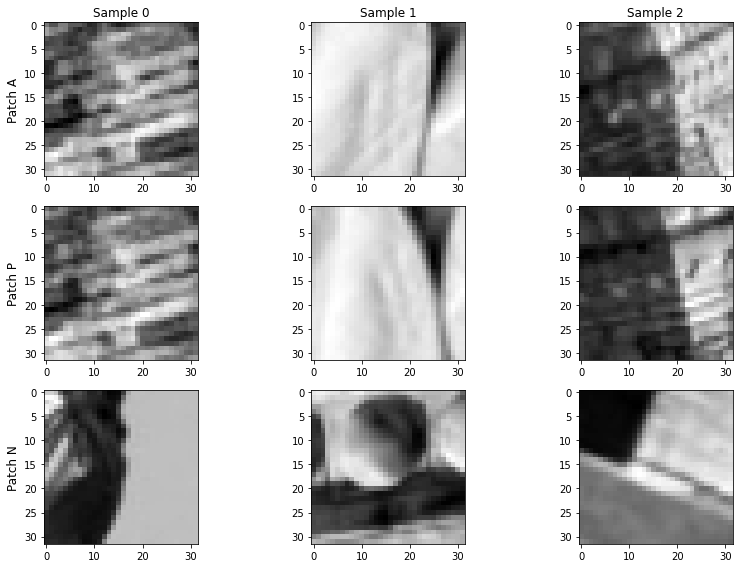

In [6]:
def plot_examples(sample_batched, n_samples=3, labels=['A', 'P', 'N']):
    
    cols = ['Sample {}'.format(col) for col in range(0, n_samples)]
    rows = ['Patch {}'.format(row) for row in labels]
    nrow = len(rows)
    
    fig, axes = plt.subplots(nrows=len(rows), ncols=n_samples, figsize=(12, 8))
    for ax, col in zip(axes[0], cols):
        ax.set_title(col)

    for ax, row in zip(axes[:,0], rows):
        ax.set_ylabel(row, rotation=90, size='large')

#     for idx, img_tensor in enumerate(sample_batched):
    for idx in range(nrow):
        img_tensor = sample_batched[idx]
        for jdx in range(n_samples):
            img = img_tensor[jdx, 0]
            axes[idx][jdx].imshow(img, cmap='gray')

    fig.tight_layout()
    plt.show()

for i_batch, sample_batched in enumerate(train_loader):
    print("In training and validation, each data entry generates {} elements: anchor, positive, and negative.".format(len(sample_batched)))
    print("Each of them have the size of: {}".format(sample_batched[0].shape))
    print("Below we show in each column one triplet: top row shows patch a; mid row shows patch p; and bot row shows patch n.")
          
    if i_batch == 0:
        plot_examples(sample_batched, 3)
        break



---
---
<a id='build_network_cell'></a>
## Build an exmaple deep network  

In this section, we will:
#### 1. [Build the deep network: DesNet](#build_desNet_cell)
#### 2. [Setup optimization](#set_opt_cell)

[BackToTop](#top_cell)

---

<a id='build_desNet_cell'></a>
### Build the deep network: DesNet
The DesNet is a simple CNN network, which only contains two CNN blocks.


[BackToSection](#build_network_cell)

In [7]:
# load network from the python file. You need to submit these .py files to TA
#from CNN1 import DesNet       # uncomment this line if you are using DesNet from CNN1.py
#from CNN2 import DesNet      # uncomment this line if you are using DesNet from CNN2.py
from CNN3 import DesNet      # uncomment this line if you are using DesNet from CNN3.py

model = DesNet()
# check model architecture

print(model)

if args.cuda:
    model.cuda()

DesNet(
  (features): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(64, 96, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (13): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (14): ReLU

<a id='set_opt_cell'></a>
### Define optimization
We will use SGD, but you can change it to ADAM by modifying arg.lr in config_profile.py

[BackToSection](#build_network_cell)

In [8]:
# define optimizer
def create_optimizer(model, new_lr):
    # setup optimizer
    if args.optimizer == 'sgd':
        optimizer = optim.SGD(model.parameters(), lr=new_lr,
                              momentum=0.9, dampening=0.9,
                              weight_decay=args.wd)
    else:
        raise Exception('Not supported optimizer: {0}'.format(args.optimizer))
    return optimizer
optimizer1 = create_optimizer(model.features, args.lr)

---
---
<a id='train_network_cell'></a>
## train the deep network  
In this section, we will:
#### 1. [Define a training module](#define_train_module_cell)
#### 2. [Define a testing module](#define_test_module_cell)
#### 3. [Train and test on the validation data](#training_module_cell)

[BackToTop](#top_cell)

---

<a id='define_train_module_cell'></a>
### Define a training module

[BackToSection](#train_network_cell)

In [9]:
def train(train_loader, model, optimizer, epoch, logger, load_triplets  = False):      #Loss
    # switch to train mode
    loss_item = 0
    model.train()
    pbar = tqdm(enumerate(train_loader))
    for batch_idx, data in pbar:
        data_a, data_p, data_n = data
        

        if args.cuda:
            data_a, data_p, data_n  = data_a.cuda(), data_p.cuda(), data_n.cuda()
            out_a = model(data_a)
            out_p = model(data_p)
            out_n = model(data_n)
        
        loss = loss_DesNet(out_a, out_p, out_n, anchor_swap = False, margin = 1.0, loss_type = "triplet_margin")
                
        if args.decor:
            loss += CorrelationPenaltyLoss()(out_a)
            
        if args.gor:
            loss += args.alpha*global_orthogonal_regularization(out_a, out_n)
            
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        adjust_learning_rate(optimizer)
        if batch_idx % args.log_interval == 0:
            pbar.set_description(
                'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                    epoch, batch_idx * len(data_a), len(train_loader.dataset),
                           100. * batch_idx / len(train_loader),
                    loss.item()))
            #print('loss:', loss.item())
            
            
        loss_item = loss_item + loss.item()
        
    #print('total_loss:',loss_item )
    #print('times:',len(train_loader) )
    ave_loss = loss_item / len(train_loader)
    print('ave_loss:', ave_loss)
    all_aveloss.append(ave_loss)
    
    

    if (args.enable_logging):
        logger.log_value('loss', loss.item()).step()

    try:
        os.stat('{}{}'.format(args.model_dir,suffix))
    except:
        os.makedirs('{}{}'.format(args.model_dir,suffix))

    torch.save({'epoch': epoch + 1, 'state_dict': model.state_dict()},
               '{}{}/checkpoint_{}.pth'.format(args.model_dir,suffix,epoch))
   
    all_epoch.append(epoch)
     
    
def adjust_learning_rate(optimizer):
    """Updates the learning rate given the learning rate decay.
    The routine has been implemented according to the original Lua SGD optimizer
    """
    for group in optimizer.param_groups:
        if 'step' not in group:
            group['step'] = 0.
        else:
            group['step'] += 1.
        group['lr'] = args.lr * (
        1.0 - float(group['step']) * float(args.batch_size) / (args.n_triplets * float(args.epochs)))
    return

<a id='define_test_module_cell'></a>
### Define a testing module
[BackToSection](#train_network_cell)

In [10]:
def test(test_loader, model, epoch, logger, logger_test_name):   #Loss on validation
    # switch to evaluate mode
    model.eval()

    losses = 0

    pbar = tqdm(enumerate(test_loader))
    
    for batch_idx, data in pbar:
        data_a, data_p, data_n = data
        

        if args.cuda:
            data_a, data_p, data_n  = data_a.cuda(), data_p.cuda(), data_n.cuda()
            out_a = model(data_a)
            out_p = model(data_p)
            out_n = model(data_n)
        
        loss = loss_DesNet(out_a, out_p, out_n, anchor_swap = False, margin = 1.0, loss_type = "triplet_margin")
        losses = losses + loss.cpu().numpy()
    ave_loss = losses/len(test_loader)
    print('\33[91mLoss on validation: {:.8f}\n\33[0m'.format(ave_loss))
    all_vloss.append(ave_loss)

    if (args.enable_logging):
        logger.log_value(logger_test_name+' vloss', ave_loss)
    return


def ErrorRateAt95Recall(labels, scores):
    distances = 1.0 / (scores + 1e-8)
    recall_point = 0.95
    labels = labels[np.argsort(distances)]
    # Sliding threshold: get first index where recall >= recall_point. 
    # This is the index where the number of elements with label==1 below the threshold reaches a fraction of 
    # 'recall_point' of the total number of elements with label==1. 
    # (np.argmax returns the first occurrence of a '1' in a bool array). 
    threshold_index = np.argmax(np.cumsum(labels) >= recall_point * np.sum(labels)) 

    FP = np.sum(labels[:threshold_index] == 0) # Below threshold (i.e., labelled positive), but should be negative
    TN = np.sum(labels[threshold_index:] == 0) # Above threshold (i.e., labelled negative), and should be negative
    return float(FP) / float(FP + TN)

<a id='training_module_cell'></a>
### Training 

[BackToSection](#train_network_cell)

Train Epoch: 0 [99840/100000 (100%)]	Loss: 0.381983: : 3125it [01:38, 31.79it/s]


ave_loss: 0.38197849207401274


98it [00:43,  2.25it/s]


Loss on validation: 0.28725232

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 64555.38it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 59676.85it/s]
Train Epoch: 1 [99840/100000 (100%)]	Loss: 0.300182: : 3125it [01:34, 32.94it/s]


ave_loss: 0.33202793123722074


98it [00:42,  2.32it/s]


Loss on validation: 0.31261391

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 64551.39it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 61077.42it/s]
Train Epoch: 2 [99840/100000 (100%)]	Loss: 0.437191: : 3125it [01:34, 33.16it/s]


ave_loss: 0.318922604906559


98it [00:42,  2.29it/s]


Loss on validation: 0.29300233

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 64935.56it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 61503.73it/s]
Train Epoch: 3 [99840/100000 (100%)]	Loss: 0.251653: : 3125it [01:33, 33.37it/s]


ave_loss: 0.306563486828804


98it [00:42,  2.30it/s]


Loss on validation: 0.29285870

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 63892.07it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 57124.93it/s]
Train Epoch: 4 [99840/100000 (100%)]	Loss: 0.155652: : 3125it [01:34, 33.12it/s]


ave_loss: 0.28963429572820665


98it [00:43,  2.27it/s]


Loss on validation: 0.28751215

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 63991.01it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 61132.23it/s]
Train Epoch: 5 [99840/100000 (100%)]	Loss: 0.243228: : 3125it [01:33, 33.33it/s]


ave_loss: 0.28057940925121305


98it [00:43,  2.26it/s]


Loss on validation: 0.27892809

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 64372.31it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 61508.60it/s]
Train Epoch: 6 [99840/100000 (100%)]	Loss: 0.273447: : 3125it [01:32, 33.72it/s]


ave_loss: 0.2727759683322907


98it [00:42,  2.28it/s]


Loss on validation: 0.27594451

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 64177.35it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 59150.42it/s]
Train Epoch: 7 [99840/100000 (100%)]	Loss: 0.303738: : 3125it [01:34, 33.07it/s]


ave_loss: 0.2708574397158623


98it [00:44,  2.20it/s]


Loss on validation: 0.27958200

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 57118.69it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 53462.73it/s]
Train Epoch: 8 [99840/100000 (100%)]	Loss: 0.150301: : 3125it [01:39, 31.48it/s]


ave_loss: 0.2658605541443825


98it [00:41,  2.34it/s]


Loss on validation: 0.27201380

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 62882.03it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 60000.82it/s]
Train Epoch: 9 [99840/100000 (100%)]	Loss: 0.268860: : 3125it [01:31, 34.14it/s]


ave_loss: 0.2633916282939911


98it [00:41,  2.36it/s]


Loss on validation: 0.27860408

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 65886.09it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 63130.41it/s]
Train Epoch: 10 [99840/100000 (100%)]	Loss: 0.213009: : 3125it [01:33, 33.40it/s]


ave_loss: 0.2592742396068573


98it [00:41,  2.35it/s]


Loss on validation: 0.27645970

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 65189.35it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 60158.00it/s]
Train Epoch: 11 [99840/100000 (100%)]	Loss: 0.368976: : 3125it [01:32, 33.75it/s]


ave_loss: 0.25566112244844436


98it [00:42,  2.32it/s]


Loss on validation: 0.26484685

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 63180.53it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 61561.68it/s]
Train Epoch: 12 [99840/100000 (100%)]	Loss: 0.284492: : 3125it [01:35, 32.69it/s]


ave_loss: 0.25432900408744813


98it [00:42,  2.33it/s]


Loss on validation: 0.26894524

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 63038.99it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 59004.21it/s]
Train Epoch: 13 [99840/100000 (100%)]	Loss: 0.235388: : 3125it [01:36, 32.49it/s]


ave_loss: 0.25014324797153475


98it [00:42,  2.32it/s]


Loss on validation: 0.27291425

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 64890.81it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 62834.80it/s]
Train Epoch: 14 [99840/100000 (100%)]	Loss: 0.257453: : 3125it [01:35, 32.79it/s]


ave_loss: 0.24491660046339034


98it [00:42,  2.33it/s]


Loss on validation: 0.28044749

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 62498.19it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 60528.52it/s]
Train Epoch: 15 [99840/100000 (100%)]	Loss: 0.256197: : 3125it [01:32, 33.95it/s]


ave_loss: 0.23933690375566483


98it [00:41,  2.34it/s]


Loss on validation: 0.26854551

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 64219.40it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 62310.95it/s]
Train Epoch: 16 [99840/100000 (100%)]	Loss: 0.230694: : 3125it [01:31, 34.17it/s]


ave_loss: 0.23712341762781144


98it [00:42,  2.33it/s]


Loss on validation: 0.25924343

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 64485.04it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 61268.46it/s]
Train Epoch: 17 [99840/100000 (100%)]	Loss: 0.176592: : 3125it [01:33, 33.40it/s]


ave_loss: 0.23284473556995391


98it [00:42,  2.32it/s]


Loss on validation: 0.26759835

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 63505.26it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 59193.98it/s]
Train Epoch: 18 [99840/100000 (100%)]	Loss: 0.342152: : 3125it [01:32, 33.71it/s]


ave_loss: 0.2311421190738678


98it [00:43,  2.26it/s]


Loss on validation: 0.26079869

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 54902.72it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 52254.19it/s]
Train Epoch: 19 [99840/100000 (100%)]	Loss: 0.151592: : 3125it [01:31, 34.31it/s]


ave_loss: 0.22950921633958818


98it [00:42,  2.28it/s]


Loss on validation: 0.25568042

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 56891.87it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 50770.43it/s]
Train Epoch: 20 [99840/100000 (100%)]	Loss: 0.194231: : 3125it [01:45, 29.64it/s]


ave_loss: 0.2247313382458687


98it [00:51,  1.89it/s]


Loss on validation: 0.25737370

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 55590.32it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 55006.55it/s]
Train Epoch: 21 [99840/100000 (100%)]	Loss: 0.233137: : 3125it [01:48, 28.70it/s]


ave_loss: 0.2222505121898651


98it [00:43,  2.27it/s]


Loss on validation: 0.25693784

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 64055.06it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 61724.11it/s]
Train Epoch: 22 [99840/100000 (100%)]	Loss: 0.300783: : 3125it [01:35, 32.62it/s]


ave_loss: 0.21989015120267869


98it [00:42,  2.33it/s]


Loss on validation: 0.24958652

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 64814.40it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 61350.60it/s]
Train Epoch: 23 [99840/100000 (100%)]	Loss: 0.207704: : 3125it [01:34, 33.02it/s]


ave_loss: 0.21900237015724183


98it [00:42,  2.31it/s]


Loss on validation: 0.24396478

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 64941.44it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 62647.35it/s]
Train Epoch: 24 [99840/100000 (100%)]	Loss: 0.183085: : 3125it [01:34, 33.23it/s]


ave_loss: 0.21540467124700546


98it [00:42,  2.33it/s]


Loss on validation: 0.25227463

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 64499.82it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 59660.49it/s]
Train Epoch: 25 [99840/100000 (100%)]	Loss: 0.136525: : 3125it [01:32, 33.86it/s]


ave_loss: 0.21299760719656943


98it [00:41,  2.34it/s]


Loss on validation: 0.25105197

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 64423.81it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 62289.25it/s]
Train Epoch: 26 [99840/100000 (100%)]	Loss: 0.356733: : 3125it [01:33, 33.54it/s]


ave_loss: 0.2119810683631897


98it [00:41,  2.34it/s]


Loss on validation: 0.25476702

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 62702.51it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 61464.81it/s]
Train Epoch: 27 [99840/100000 (100%)]	Loss: 0.174300: : 3125it [01:31, 33.98it/s]


ave_loss: 0.2117344858419895


98it [00:42,  2.33it/s]


Loss on validation: 0.25106265

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 65156.94it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 62550.43it/s]
Train Epoch: 28 [99840/100000 (100%)]	Loss: 0.223610: : 3125it [01:32, 33.66it/s]


ave_loss: 0.2090374957740307


98it [00:41,  2.34it/s]


Loss on validation: 0.24935537

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 62283.82it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 62138.06it/s]
Train Epoch: 29 [99840/100000 (100%)]	Loss: 0.325316: : 3125it [01:32, 33.72it/s]


ave_loss: 0.20870134605169297


98it [00:41,  2.34it/s]


Loss on validation: 0.25178523

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 64520.27it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 62446.11it/s]
Train Epoch: 30 [99840/100000 (100%)]	Loss: 0.180378: : 3125it [01:33, 33.59it/s]


ave_loss: 0.20660881603360176


98it [00:42,  2.32it/s]


Loss on validation: 0.25324351

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 64859.29it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 59600.54it/s]
Train Epoch: 31 [99840/100000 (100%)]	Loss: 0.206768: : 3125it [01:32, 33.94it/s]


ave_loss: 0.20659646924734115


98it [00:42,  2.31it/s]


Loss on validation: 0.25224012

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 64511.20it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 62148.37it/s]
Train Epoch: 32 [99840/100000 (100%)]	Loss: 0.218682: : 3125it [01:31, 34.05it/s]


ave_loss: 0.20452820397496224


98it [00:43,  2.27it/s]


Loss on validation: 0.25104058

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 61513.24it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 61871.59it/s]
Train Epoch: 33 [99840/100000 (100%)]	Loss: 0.135796: : 3125it [01:31, 33.98it/s]


ave_loss: 0.2052405365014076


98it [00:45,  2.14it/s]


Loss on validation: 0.25460293

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 65282.68it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 62626.66it/s]
Train Epoch: 34 [99840/100000 (100%)]	Loss: 0.249570: : 3125it [01:33, 33.33it/s]


ave_loss: 0.2029575262093544


98it [00:42,  2.33it/s]


Loss on validation: 0.26114595

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 64118.85it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 61740.26it/s]
Train Epoch: 35 [99840/100000 (100%)]	Loss: 0.197294: : 3125it [01:32, 33.77it/s]


ave_loss: 0.20176960209608077


98it [00:41,  2.35it/s]


Loss on validation: 0.24811328

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 64327.15it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 62060.80it/s]
Train Epoch: 36 [99840/100000 (100%)]	Loss: 0.192550: : 3125it [01:39, 31.44it/s]


ave_loss: 0.199925116032362


98it [00:42,  2.33it/s]


Loss on validation: 0.25347734

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 60337.72it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 59256.65it/s]
Train Epoch: 37 [99840/100000 (100%)]	Loss: 0.142702: : 3125it [01:35, 32.76it/s]


ave_loss: 0.20119314696907997


98it [00:44,  2.20it/s]


Loss on validation: 0.24790345

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 57005.28it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 55335.93it/s]
Train Epoch: 38 [99840/100000 (100%)]	Loss: 0.209146: : 3125it [01:30, 34.53it/s]


ave_loss: 0.19854113484740257


98it [00:41,  2.34it/s]


Loss on validation: 0.24935682

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 61464.14it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 61473.09it/s]
Train Epoch: 39 [99840/100000 (100%)]	Loss: 0.158135: : 3125it [01:31, 34.07it/s]


ave_loss: 0.19709208837747574


98it [00:41,  2.34it/s]


Loss on validation: 0.25484597

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 62552.22it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 61120.70it/s]
Train Epoch: 40 [99840/100000 (100%)]	Loss: 0.165627: : 3125it [01:30, 34.55it/s]


ave_loss: 0.19692391590118408


98it [00:41,  2.33it/s]


Loss on validation: 0.25392589

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 65726.01it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 60345.56it/s]
Train Epoch: 41 [99840/100000 (100%)]	Loss: 0.226053: : 3125it [01:31, 34.20it/s]


ave_loss: 0.19689172567248345


98it [00:47,  2.07it/s]


Loss on validation: 0.24899755

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 62558.11it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 60910.99it/s]
Train Epoch: 42 [99840/100000 (100%)]	Loss: 0.122201: : 3125it [01:31, 34.25it/s]


ave_loss: 0.19502321634054184


98it [00:41,  2.35it/s]


Loss on validation: 0.24255105

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 65069.60it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 59041.84it/s]
Train Epoch: 43 [99840/100000 (100%)]	Loss: 0.177302: : 3125it [01:32, 33.68it/s]


ave_loss: 0.19578233588576316


98it [00:42,  2.33it/s]


Loss on validation: 0.25132652

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 64633.69it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 58496.54it/s]
Train Epoch: 44 [99840/100000 (100%)]	Loss: 0.186948: : 3125it [01:32, 33.69it/s]


ave_loss: 0.19379122129678727


98it [00:49,  1.97it/s]


Loss on validation: 0.24660023

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 61532.25it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 60998.45it/s]
Train Epoch: 45 [99840/100000 (100%)]	Loss: 0.130194: : 3125it [01:31, 34.08it/s]


ave_loss: 0.19362239396214484


98it [00:44,  2.18it/s]


Loss on validation: 0.25036500

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 56489.42it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 54058.95it/s]
Train Epoch: 46 [99840/100000 (100%)]	Loss: 0.146553: : 3125it [01:30, 34.65it/s]


ave_loss: 0.19236716393470765


98it [00:42,  2.33it/s]


Loss on validation: 0.24599169

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 65844.76it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 62635.43it/s]
Train Epoch: 47 [99840/100000 (100%)]	Loss: 0.257117: : 3125it [01:31, 34.09it/s]


ave_loss: 0.1913409202504158


98it [00:44,  2.22it/s]


Loss on validation: 0.24661696

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 64833.49it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 58976.65it/s]
Train Epoch: 48 [99840/100000 (100%)]	Loss: 0.272054: : 3125it [01:34, 32.92it/s]


ave_loss: 0.18987999124526977


98it [00:42,  2.32it/s]


Loss on validation: 0.24212204

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 64680.47it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 59048.68it/s]
Train Epoch: 49 [99840/100000 (100%)]	Loss: 0.235620: : 3125it [01:32, 33.86it/s]


ave_loss: 0.19131201102137566


98it [00:41,  2.35it/s]


Loss on validation: 0.24601727

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 56783.97it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 61839.00it/s]
Train Epoch: 50 [99840/100000 (100%)]	Loss: 0.209991: : 3125it [01:32, 33.73it/s]


ave_loss: 0.18952245636463166


98it [00:41,  2.35it/s]


Loss on validation: 0.25179289

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 63097.24it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 62843.06it/s]
Train Epoch: 51 [99840/100000 (100%)]	Loss: 0.155204: : 3125it [01:33, 33.48it/s]


ave_loss: 0.18685571746349336


98it [00:41,  2.35it/s]


Loss on validation: 0.24139979

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 65342.11it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 60839.93it/s]
Train Epoch: 52 [99840/100000 (100%)]	Loss: 0.282696: : 3125it [01:33, 33.43it/s]


ave_loss: 0.18611773099541665


98it [00:41,  2.35it/s]


Loss on validation: 0.25074270

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 65818.47it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 62948.15it/s]
Train Epoch: 53 [99840/100000 (100%)]	Loss: 0.150974: : 3125it [01:32, 33.94it/s]


ave_loss: 0.18571382741689682


98it [00:41,  2.35it/s]


Loss on validation: 0.24632535

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 65830.81it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 61781.53it/s]
Train Epoch: 54 [99840/100000 (100%)]	Loss: 0.186545: : 3125it [01:33, 33.26it/s]


ave_loss: 0.18491989680051804


98it [00:43,  2.23it/s]


Loss on validation: 0.24654816

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 57437.14it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 51691.19it/s]
Train Epoch: 55 [99840/100000 (100%)]	Loss: 0.100586: : 3125it [01:36, 32.51it/s]


ave_loss: 0.1833152724647522


98it [00:41,  2.34it/s]


Loss on validation: 0.24257731

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 64141.13it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 61702.22it/s]
Train Epoch: 56 [99840/100000 (100%)]	Loss: 0.129605: : 3125it [01:32, 33.95it/s]


ave_loss: 0.18396136807441713


98it [00:42,  2.33it/s]


Loss on validation: 0.25446517

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 62453.86it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 62378.17it/s]
Train Epoch: 57 [99840/100000 (100%)]	Loss: 0.232096: : 3125it [01:31, 33.98it/s]


ave_loss: 0.18479146708250047


98it [00:42,  2.33it/s]


Loss on validation: 0.24292387

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 64652.05it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 61542.01it/s]
Train Epoch: 58 [99840/100000 (100%)]	Loss: 0.118088: : 3125it [01:31, 34.01it/s]


ave_loss: 0.18224295067667962


98it [00:41,  2.35it/s]


Loss on validation: 0.24075186

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 64913.82it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 61682.13it/s]
Train Epoch: 59 [99840/100000 (100%)]	Loss: 0.184042: : 3125it [01:32, 33.80it/s]


ave_loss: 0.18277710996985436


98it [00:42,  2.33it/s]


Loss on validation: 0.24553264

# Found cached data data/sets/liberty.pt


100%|██████████| 100000/100000 [00:01<00:00, 65192.33it/s]


# Found cached data data/sets/notredame.pt


100%|██████████| 100000/100000 [00:01<00:00, 62654.97it/s]


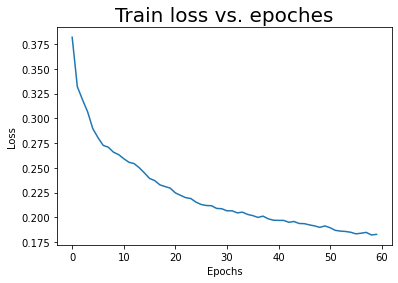

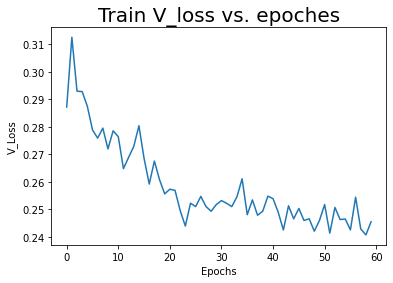

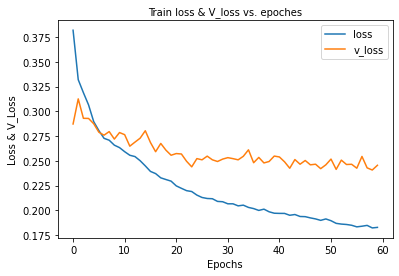

epoch: 0   ave_loss: 0.38197849207401274
epoch: 1   ave_loss: 0.33202793123722074
epoch: 2   ave_loss: 0.318922604906559
epoch: 3   ave_loss: 0.306563486828804
epoch: 4   ave_loss: 0.28963429572820665
epoch: 5   ave_loss: 0.28057940925121305
epoch: 6   ave_loss: 0.2727759683322907
epoch: 7   ave_loss: 0.2708574397158623
epoch: 8   ave_loss: 0.2658605541443825
epoch: 9   ave_loss: 0.2633916282939911
epoch: 10   ave_loss: 0.2592742396068573
epoch: 11   ave_loss: 0.25566112244844436
epoch: 12   ave_loss: 0.25432900408744813
epoch: 13   ave_loss: 0.25014324797153475
epoch: 14   ave_loss: 0.24491660046339034
epoch: 15   ave_loss: 0.23933690375566483
epoch: 16   ave_loss: 0.23712341762781144
epoch: 17   ave_loss: 0.23284473556995391
epoch: 18   ave_loss: 0.2311421190738678
epoch: 19   ave_loss: 0.22950921633958818
epoch: 20   ave_loss: 0.2247313382458687
epoch: 21   ave_loss: 0.2222505121898651
epoch: 22   ave_loss: 0.21989015120267869
epoch: 23   ave_loss: 0.21900237015724183
epoch: 24   av

In [11]:
all_aveloss = []
all_vloss = []
all_epoch = []
compare = []


start = args.start_epoch
end = start + args.epochs
logger, file_logger = None, None
triplet_flag = args.load_random_triplets
from Losses import loss_DesNet
TEST_ON_W1BS = True
LOG_DIR = args.log_dir
if(args.enable_logging):
    from Loggers import Logger, FileLogger
    logger = Logger(LOG_DIR)
    
suffix = '{}_{}_{}_as_fliprot'.format(args.experiment_name, args.training_set, args.batch_reduce)

res_fpr_liberty = torch.zeros(end-start,1)
res_fpr_notredame = torch.zeros(end-start, 1)
res_fpr_yosemite = torch.zeros(end-start, 1)

for epoch in range(start, end):

    # iterate over test loaders and test results
    train(train_loader, model, optimizer1, epoch, logger, triplet_flag)
    with torch.no_grad():
        test(validation_loader['dataloader'], model, epoch, logger, validation_loader['name'])

    #randomize train loader batches
    train_loader, _ = create_loaders(dataset_names, load_random_triplets=triplet_flag)

plt.figure()
x1 = range(0,len(all_epoch))
y1 = all_aveloss
plt.title('Train loss vs. epoches', fontsize=20)
plt.plot(x1, y1)
plt.ylabel('Loss', fontsize=10)
plt.xlabel('Epochs', fontsize=10)
plt.savefig("imgPath/cnn3_32_0.1_loss.jpg")
plt.show()

plt.figure()
x2 = range(0,len(all_epoch))
y2 = all_vloss
plt.title('Train V_loss vs. epoches', fontsize=20)
plt.plot(x2, y2)
plt.ylabel('V_Loss', fontsize=10)
plt.xlabel('Epochs', fontsize=10)
plt.savefig("imgPath/cnn3_32_0.1_vloss.jpg")
plt.show()

plt.figure()
x = range(0,len(all_epoch))
y1 = all_aveloss
y2 = all_vloss
plt.title('Train loss & V_loss vs. epoches', fontsize=10)
plt.plot(x, y1, label='loss')
plt.plot(x, y2, label='v_loss')
plt.ylabel('Loss & V_Loss', fontsize=10)
plt.xlabel('Epochs', fontsize=10)
plt.legend(['loss', 'v_loss'], loc='upper right') 
plt.savefig("imgPath/cnn3_32_0.1_loss&vloss.jpg")
plt.show()

for i in range(len(all_aveloss)):
    print('epoch:', i,' ','ave_loss:',all_aveloss[i])
    
    
print('\n')

for j in range(len(all_aveloss)):
    diff = abs(all_aveloss[j] - all_vloss[j])
    compare.append(diff)
    print('epoch:', j, 'diff:', diff)

print('\n')

print('min all_aveloss:',min(all_aveloss))
print('min all_vloss:',min(all_vloss))
print('compare:', min(compare))


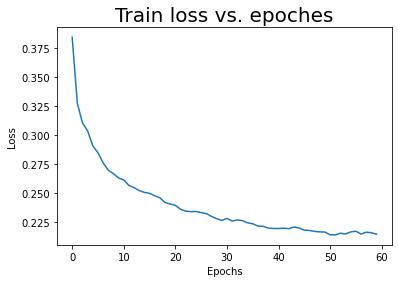

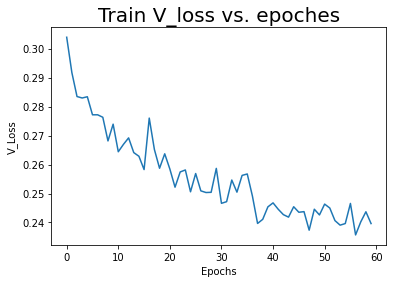

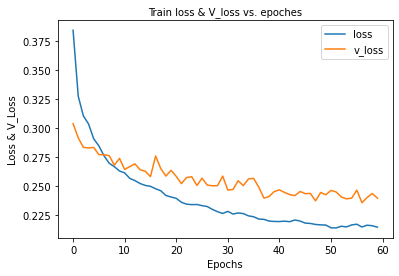

epoch: 0   ave_loss: 0.3843980565690994
epoch: 1   ave_loss: 0.32751359260082247
epoch: 2   ave_loss: 0.3105444423055649
epoch: 3   ave_loss: 0.30361376041889193
epoch: 4   ave_loss: 0.29085388281822205
epoch: 5   ave_loss: 0.28470597509384155
epoch: 6   ave_loss: 0.27617358204841613
epoch: 7   ave_loss: 0.2697829394459724
epoch: 8   ave_loss: 0.2667827891898155
epoch: 9   ave_loss: 0.2630725799870491
epoch: 10   ave_loss: 0.26143564495801924
epoch: 11   ave_loss: 0.2566937720441818
epoch: 12   ave_loss: 0.2547467728662491
epoch: 13   ave_loss: 0.25225285979747775
epoch: 14   ave_loss: 0.2506391504263878
epoch: 15   ave_loss: 0.24985642176389694
epoch: 16   ave_loss: 0.2477466260409355
epoch: 17   ave_loss: 0.2460395177078247
epoch: 18   ave_loss: 0.2419627627158165
epoch: 19   ave_loss: 0.24064292558193207
epoch: 20   ave_loss: 0.2395227234840393
epoch: 21   ave_loss: 0.2361210816681385
epoch: 22   ave_loss: 0.23448545515298844
epoch: 23   ave_loss: 0.2340907411289215
epoch: 24   ave_

In [12]:
plt.figure()
x1 = range(0,len(all_epoch))
y1 = all_aveloss
plt.title('Train loss vs. epoches', fontsize=20)
plt.plot(x1, y1)
plt.ylabel('Loss', fontsize=10)
plt.xlabel('Epochs', fontsize=10)
plt.savefig("imgPath/cnn3_32_0.0001_loss.jpg")
plt.show()

plt.figure()
x2 = range(0,len(all_epoch))
y2 = all_vloss
plt.title('Train V_loss vs. epoches', fontsize=20)
plt.plot(x2, y2)
plt.ylabel('V_Loss', fontsize=10)
plt.xlabel('Epochs', fontsize=10)
plt.savefig("imgPath/cnn3_32_0.0001_vloss.jpg")
plt.show()

plt.figure()
x = range(0,len(all_epoch))
y1 = all_aveloss
y2 = all_vloss
plt.title('Train loss & V_loss vs. epoches', fontsize=10)
plt.plot(x, y1, label='loss')
plt.plot(x, y2, label='v_loss')
plt.ylabel('Loss & V_Loss', fontsize=10)
plt.xlabel('Epochs', fontsize=10)
plt.legend(['loss', 'v_loss'], loc='upper right') 
plt.savefig("imgPath/cnn3_32_0.0001_loss&vloss.jpg")
plt.show()

for i in range(len(all_aveloss)):
    print('epoch:', i,' ','ave_loss:',all_aveloss[i])
    
    
print('\n')

for j in range(len(all_aveloss)):
    diff = abs(all_aveloss[j] - all_vloss[j])
    compare.append(diff)
    print('epoch:', j, 'diff:', diff)

print('\n')

print('min all_aveloss:',min(all_aveloss))
print('min all_vloss:',min(all_vloss))
print('compare:', min(compare))


### Select the best model, and save it as CNN*.pth; * can be 1, 2, or 3.

---
---
<a id='generate_deep_features_cell'></a>
## Generate deep features
In this section, we will use your trained network to generate deep features for each patch:
#### 1. [load weights](#load_weights_module_cell)
#### 2. [load patches](#load_raw_patch_files_module_cell)
#### 3. [get deep features](#get_deep_features_module_cell)



[BackToTop](#top_cell)

<a id='load_weights_module_cell'></a>
### Load network weights
[BackToSection](#generate_deep_features_cell)

In [ ]:
trained_weight_path = "models/liberty_train/_liberty_min_as_fliprot/checkpoint_4.pth" # suppose you select  checkpoint_4.pth as the best model for this architecture
test_model = DesNet()
if args.cuda:
    test_model.cuda()
trained_weight = torch.load(trained_weight_path)['state_dict']
test_model.load_state_dict(trained_weight)
test_model.eval()

<a id='load_raw_patch_files_module_cell'></a>
### Load raw patch files
Assume that the raw patch file is stored as patches.pth

[BackToSection](#generate_deep_features_cell)

In [ ]:
patches_dir = "patches.pth"            # these patches are from keypoint detection results
patches = torch.load(patches_dir)
print(patches.shape)                  # in your case, the shape should be [10, 200, 1, 32, 32]
num_imgs, num_pts, _, _, _ = patches.shape
patches = patches[0].view(-1, 1, 32, 32).cuda()
print(patches.shape)


<a id='get_deep_features_module_cell'></a>
### Get deep features
[BackToSection](#generate_deep_features_cell)

In [14]:
features = test_model(patches)
print(features.shape)
features = features.view(num_imgs, num_pts, 128).cpu().data
print(features.shape)                  # in your case, the shape should be [10, 200, 128]

torch.Size([10, 128])
torch.Size([1, 10, 128])


In [15]:
# save to file, with the name of *_features_CNN*.pth
features_dir = "features_CNN1.pth"
torch.save(features, features_dir)